In [ ]:
import numpy as np
import numpy.linalg as npl
import scipy as sp
import scipy.sparse.linalg as spspl
import matplotlib.pyplot as plt
%pylab inline
from dolfin import *

## Définition des classes et paramètres

In [2]:
# Rayon du disque
r = 0.3

# Nombre de noeuds
N = 50

# Classes des domaines
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0)
class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 1.0)
class Bottom(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)
class Top(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 1.0)
class Gamma0(SubDomain):
    def inside(self, x, on_boundary):
        return (x[1]-0.5)**2<=r**2-(x[0]-0.5)**2 and (x[1]-0.5)**2<=r**2-(x[0]-0.5)**2

# Initialize sub-domain instances
left   = Left()
top    = Top()
right  = Right()
bottom = Bottom()
gamma  = Gamma0()

# Define mesh
mesh = UnitSquareMesh(N,N)

# Initialize mesh function for interior domains
domains = MeshFunction("size_t", mesh, mesh.topology().dim())
domains.set_all(0)         #domains 0 = all space
gamma.mark(domains, 1)     #domains 1 = all gamma0

# Initialize mesh function for boundary domains
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1) #1d domains
boundaries.set_all(0)      #boundaries 0 = all boundaries
left.mark(boundaries, 1)   #boundaries 1 = left (Neumann)
top.mark(boundaries, 2)    #boundaries 2 = top (Dirichlet)
right.mark(boundaries, 3)  #boundaries 3 = right (Neumann)
bottom.mark(boundaries, 4) #boundaries 4 = bottom (Neumann parametrized)

# Define function space and basis functions
V = FunctionSpace(mesh, "CG", 1)
u = TrialFunction(V)
v = TestFunction(V)

# Define Dirichlet boundary conditions at top and bottom boundaries
bcs = [DirichletBC(V, 0.0, boundaries, 2)]

# Define new measures associated with the interior domains and
# exterior boundaries
dx = Measure('dx', domain=mesh, subdomain_data=domains)
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

NameError: name 'SubDomain' is not defined

## Solver du problème 2D

In [3]:
def Solver(mu):
    # Define input data
    mu0 = Constant(mu[0])  
    mu1 = Constant(mu[1])
    
    # Separate left and right hand sides of equation
    a0= inner(grad(u),grad(v))*dx(0)
    def a1(mu0):
        return inner(mu0*grad(u),grad(v))*dx(1)
    a = a0 + a1(mu0) #+ inner(mu1*grad(u),grad(v))*ds(4)
    L0 = v*ds(4)
    L = mu1*L0
    
    # Passage en nd.array
    A = assemble(a)
    b = assemble(L)
    A2 = np.copy(A.array())
    b2 = np.copy(b.get_local())
    
    # Conditions de Dirichlet
    n=0
    niter=2
    for i in range((N+1)**2):
        for j in range((N+1)**2):
            if (i == n)and(i<=int((N+1)**2)/2):
                A2[i,:] = 0
                A2[i,i] = 1
                n += niter
                niter += 1
    
    # Résolution du système linéaire
    u2 = npl.solve(A2,b2)
    
    # Passage en dolfin.Function
    Sol = Function(V)
    Sol.vector().set_local(u2)
    #c = plot(Sol)
    #plt.colorbar(c)

    return np.array([Sol,A2,b2])

In [4]:
mu_test = np.array([0.4,0.1])
A = Solver(mu_test)

## Offline procedure

In [5]:
def POD_offline_procedure(total_model_solver,training_set,tol,plot = False):
    U_delta_list = []
    for mu_loop in training_set:
        if plot:
            coucou = total_model_solver(mu_loop)       #plus de False ou True
            plt.plot(coucou[0],coucou[1],label = str(mu_loop))
            U_delta_list.append(coucou[1])
        else:
            U_delta_list.append(total_model_solver(mu_loop)[0].vector().get_local())
    if plot:
        #plt.legend()
        plt.title("all different solutions for mu in training_set")
        plt.show()
    U_delta = np.array(U_delta_list)
    U,S,V = svd(U_delta)
    cumul_relat_vp = 0
    sum_vp = np.sum(S)
    for rank,vp in enumerate(S):
        cumul_relat_vp += vp/sum_vp
        if 1-cumul_relat_vp < tol:
            tronk_rank = rank
            break
    U_tr = U[:,:tronk_rank+1]
    return U_delta.T.dot(U_tr),1-cumul_relat_vp

In [6]:
def svd(U_delta):
    """
    This is not a simple svd, it's a svd-based algorithm described in 
    "Linear algebra box: Proper Orthogonal Decomposition (POD)" p.33
    """
    N,M = U_delta.shape
    wU = U_delta/np.sqrt(M)
    U,s,V = npl.svd(wU,False)
    S = s**2
    return U,S,V

In [7]:
def training_set_creator(*args):
    """
    args are a non-zero number of lists of size 3.
    Example of use: we want the creation of an iteratable representing all possible elements on a n-dimensional grid
    first dimension goes from a to b with c elements, then you pass "[a,b,c]" as a first argument.
    return: n-dimensional grid on which you can iterate.
    
    """
    linspace_args = (np.linspace(arg[0],arg[1],arg[2]) for arg in args)
    pools = [tuple(pool) for pool in linspace_args]
    result = [[]]
    for pool in pools:
        result = [x+[y] for x in result for y in pool]
    for prod in result:
        yield tuple(prod)

In [8]:
def reduced_solver(mu,A_q,shape):
    """
    from output of pre_computer and a mu: computes A_rb and f_rb and u_rb, the solution of A_rb.u_rb=f_rb
    """
    A = A_q[1]
    f = A_q[3]
    for i in range(shape):
        A += A_q[0][i]*mu[i]
    for i in range(shape,len(mu)):
        f += A_q[2][i-shape]*mu[i]
    return npl.solve(A,f)

## Precomputer

In [9]:
def pre_computer(Base):
    """
    pre_computer take as input a reduced_base and pre_computes all quantities used for a reduced_solver.
    output: [[A_rb^q](0<= i <=n1),A_rb^0,[f_rb^q](0<= i <=n2),f_rb^0],n
    with A_rb = sum_(i in 0..n1){ mu[i]*A_rb^(q_1)_i } + A_rb^0
    and  f_rb = sum_(i in n1+1..n2){ mu[i]*f_rb^(q_1)_i } + f_rb^0
            n = n1+1
    """
    #mu0 = Constant(mu[0])
    #mu1 = Constant(mu[1])
    # Separate left and right hand sides of equation
    a0= inner(grad(u),grad(v))*dx(0)
    #def a1(mu0):
    #    return inner(grad(u),grad(v))*dx(1)
    a1 = inner(grad(u),grad(v))*dx(1)

    L0 = v*ds(4)
    #L = mu1*L0
    
    A_0M = assemble(a0)
    A_1M = assemble(a1)
    b = assemble(L0)
    A_0 = np.copy(A_0M.array())
    A_1 = np.copy(A_1M.array())
    b_0 = np.copy(b.get_local())
    #n=0
    #niter=2
    #for i in range((N+1)**2):
    #    for j in range((N+1)**2):
    #        if (i == n)and(i<=int((N+1)**2)/2):
    #            A_0[i,:] = 0
    #            A_0[i,i] = 1
    #            n += niter
    #            niter += 1
                
    A0B = [Base.T.dot(A_1.dot(Base))]
    A1B = Base.T.dot(A_0.dot(Base))
    b1 = [Base.T.dot(b_0)]
    b2 = Base.T.dot(np.zeros(b_0.shape))
    
    #At = assemble(a0 + a1(mu0))
    #bt = assemble(L)
    #A = np.copy(At.array())
    #b = np.copy(bt.get_local())
    
    return [A0B,A1B,b1,b2],1 #[Base.T.dot(A.dot(Base)),Base.T.dot(b)],1

## Résolution

### Création de la base

In [10]:
T0 = np.array([1,10,10])
T1 = np.array([-1,1,10])
training_set = training_set_creator(T0,T1)
Base,error = POD_offline_procedure(Solver,training_set,0.0001)

itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération
itération


In [11]:
print(np.shape(Base))

(2601, 2)


### Truth solution for mu_test & évaluation du temps mis

In [12]:
mu_test = np.array([10,1])

In [15]:
%%time

U_true = Solver(mu_test)[0]

CPU times: user 2.5 s, sys: 162 ms, total: 2.66 s
Wall time: 1.59 s


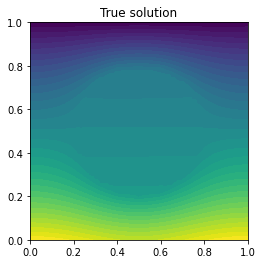

In [16]:
c = plot(U_true)
plt.title("True solution")
plt.show()

### Online procedure ne dépendant pas de mu

In [17]:
A_q,shape = pre_computer(Base)

### Résolution en base réduite & évaluation du temps

In [18]:
%%time

U_rb = reduced_solver(mu_test,A_q,shape)

CPU times: user 118 µs, sys: 8 µs, total: 126 µs
Wall time: 132 µs


(2601,)


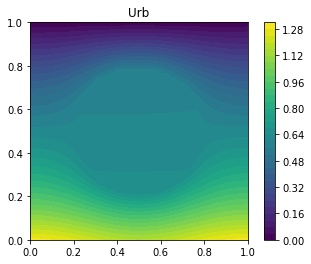

3.58104079570921e-17


In [19]:
U_rb = reduced_solver(mu_test,A_q,shape)

print(np.shape(Base.dot(U_rb)))

utmp = Function(V)
utmp.vector().set_local(Base.dot(U_rb))
aah = plot(utmp)
plt.colorbar(aah)
plt.title("Urb")
plt.show()



#plt.plot(X,Base.dot(U_rb),label="reduced_sol")
#plt.legend()
#plt.show()
print((np.max(U_true.vector().get_local()-Base.dot(U_rb))))